In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kstest, shapiro
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

import warnings
warnings.filterwarnings('ignore')

# Identify Clothing Company's Customer Behaviour Through Customer Segmentation

=====================================================================================================================

Project Objectives:
1. Identifying the distribution and correlation through Exploratory Data Analysis on each variable on the dataset
2. Segmenting the Customer Cluster based on the features on this dataset through a K-Means Unsupervised Algorithms
3. Analyzing the characteristics of each cluster and suggesting the most condition that suit to customer through an actionable insights

=====================================================================================================================

In [281]:
# import the dataset
df2 = pd.read_csv('2A.tsv', delimiter = '\t')
df2.head()

,Customer ID,Birth Date,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1,1969/03/05,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,2005/07/01,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,3,1974/12/01,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,2003/11/21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,1979/09/13,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually


## II.1. Exploratory Data Analysis

In [282]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               3900 non-null   int64  
 1   Birth Date                3900 non-null   object 
 2   Gender                    3900 non-null   object 
 3   Item Purchased            3900 non-null   object 
 4   Category                  3900 non-null   object 
 5   Purchase Amount (USD)     3900 non-null   int64  
 6   Location                  3900 non-null   object 
 7   Size                      3900 non-null   object 
 8   Color                     3900 non-null   object 
 9   Season                    3900 non-null   object 
 10  Review Rating             3900 non-null   float64
 11  Subscription Status       3900 non-null   object 
 12  Payment Method            3900 non-null   object 
 13  Shipping Type             3900 non-null   object 
 14  Discount

From the dataset's information above, we can conclude that :  
1. This dataset contains of 18 categories/columns with 3900 observation at the total
2. There are 18 independent variables at total that consists of integer, float and object datatype with no target variable
3. There is a category that contains unique identifier, which is Customer ID
4. There isnt any column that contain missing values, so it is not needed to treat the missing values

### II.1.1. Data Preparation : Ouliers Identification

At this dataset, we are asked to use the k-means clustering model. K-means is a model that used mean to calculate the centroid, which mean value is really affected by the outlier. So, we will check is there any outlier from numerical variabel, and treat it if there are some.

In [283]:
numerical = df2.select_dtypes(include = ['number'])
categorical = df2.select_dtypes(include = ['object'])
display(numerical.head(3))
display(categorical.head(3))

,Customer ID,Purchase Amount (USD),Review Rating,Previous Purchases
0,1,53,3.1,14
1,2,64,3.1,2
2,3,73,3.1,23


,Birth Date,Gender,Item Purchased,Category,Location,Size,Color,Season,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Preferred Payment Method,Frequency of Purchases
0,1969/03/05,Male,Blouse,Clothing,Kentucky,L,Gray,Winter,Yes,Credit Card,Express,Yes,Yes,Venmo,Fortnightly
1,2005/07/01,Male,Sweater,Clothing,Maine,L,Maroon,Winter,Yes,Bank Transfer,Express,Yes,Yes,Cash,Fortnightly
2,1974/12/01,Male,Jeans,Clothing,Massachusetts,S,Maroon,Spring,Yes,Cash,Free Shipping,Yes,Yes,Credit Card,Weekly


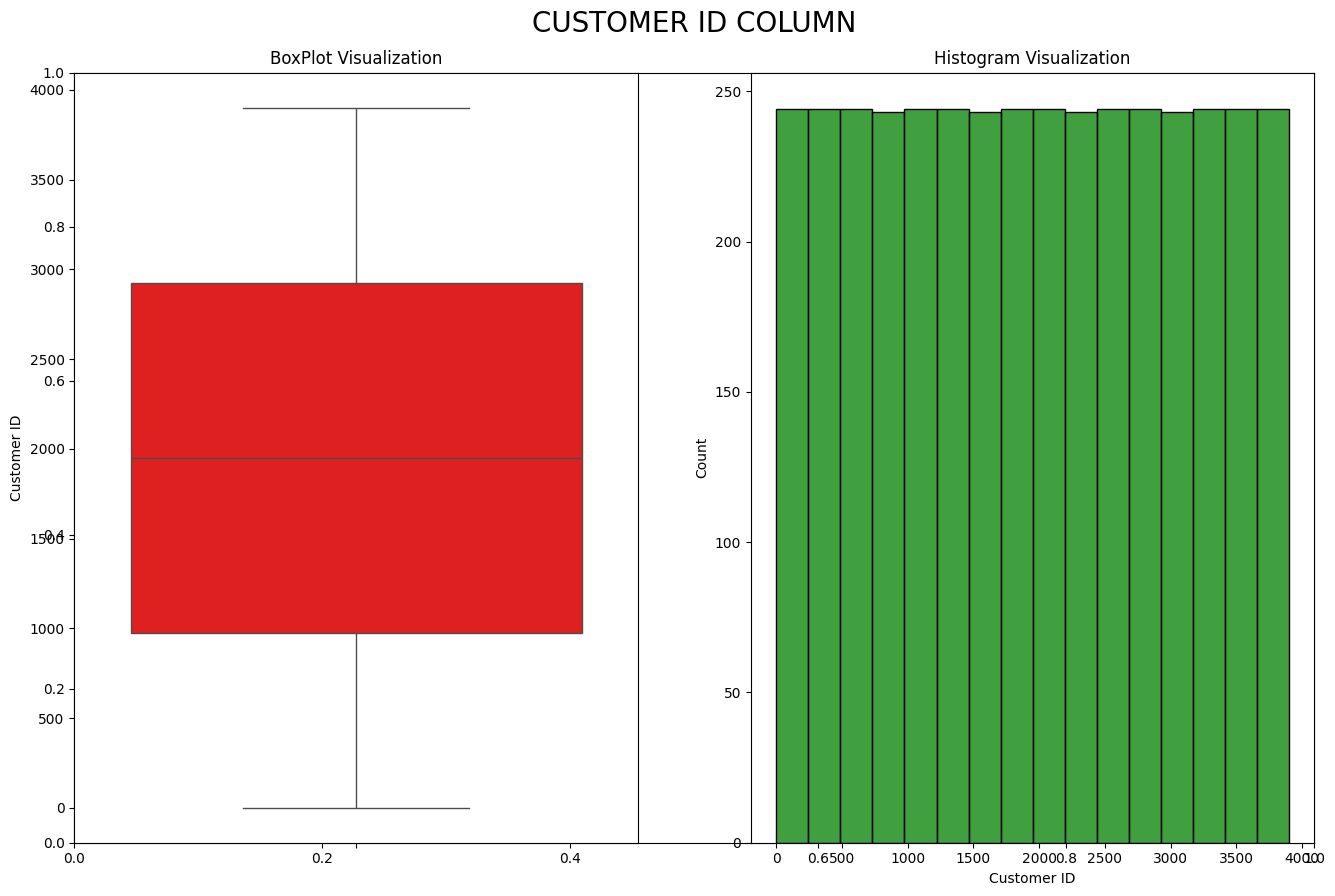

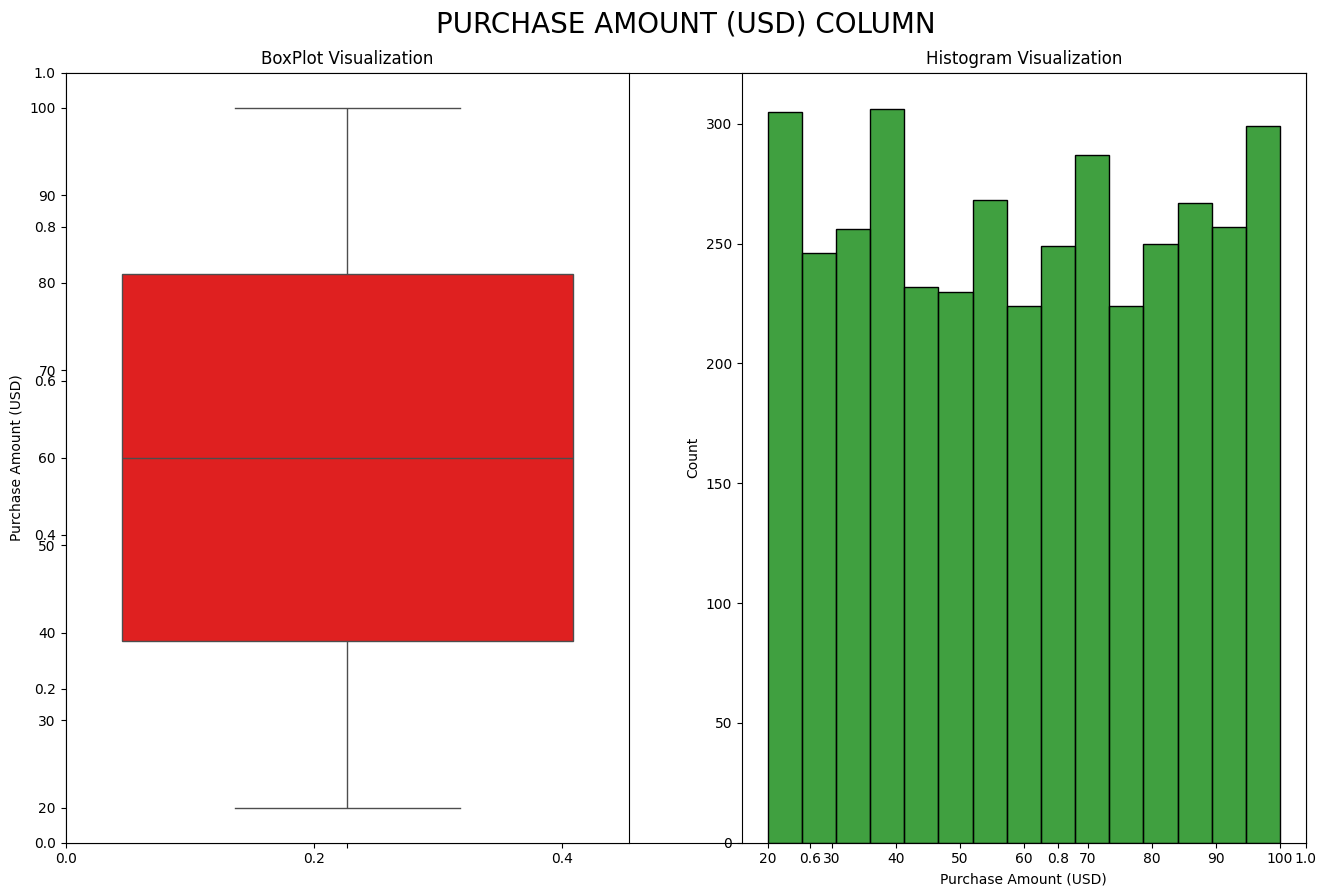

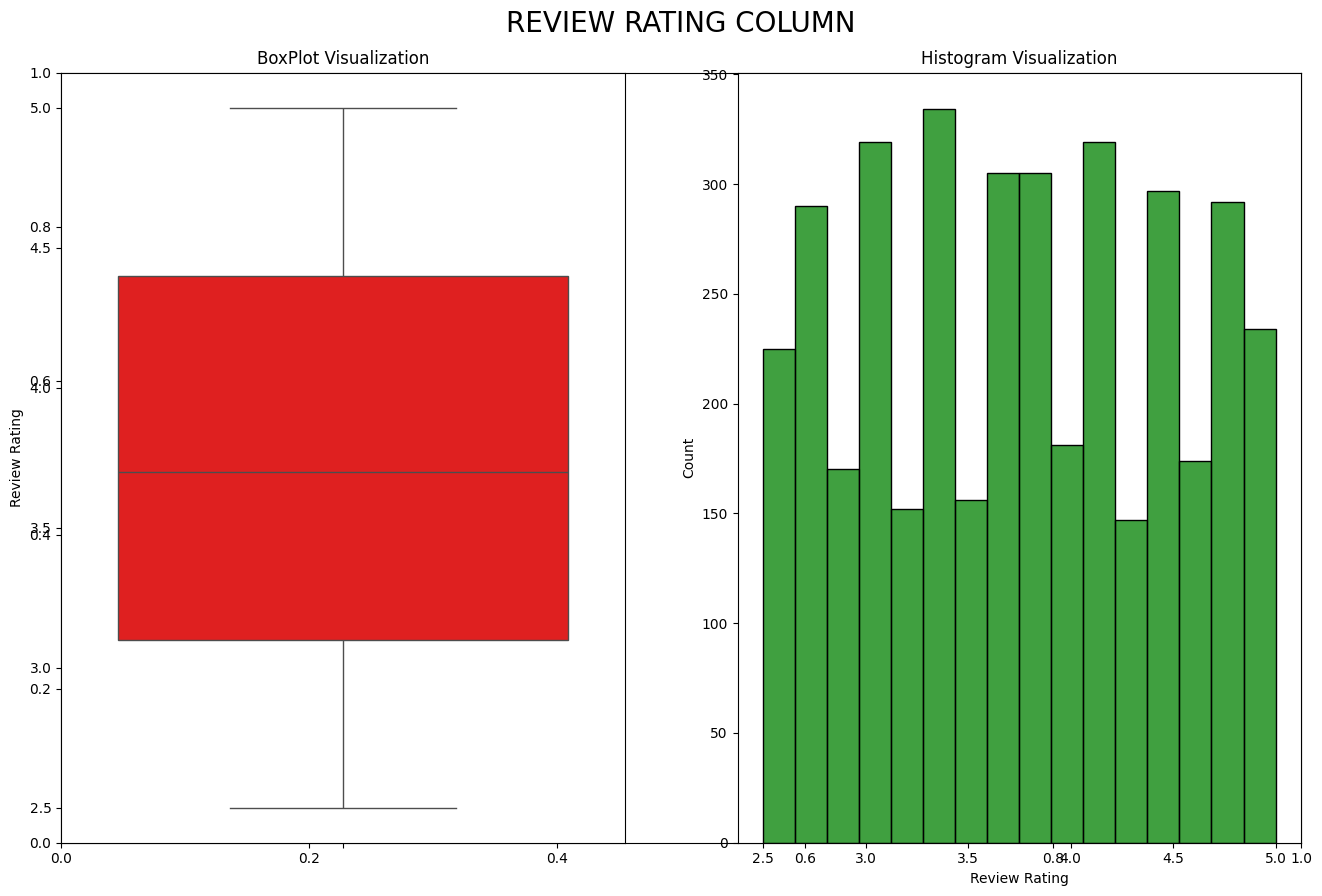

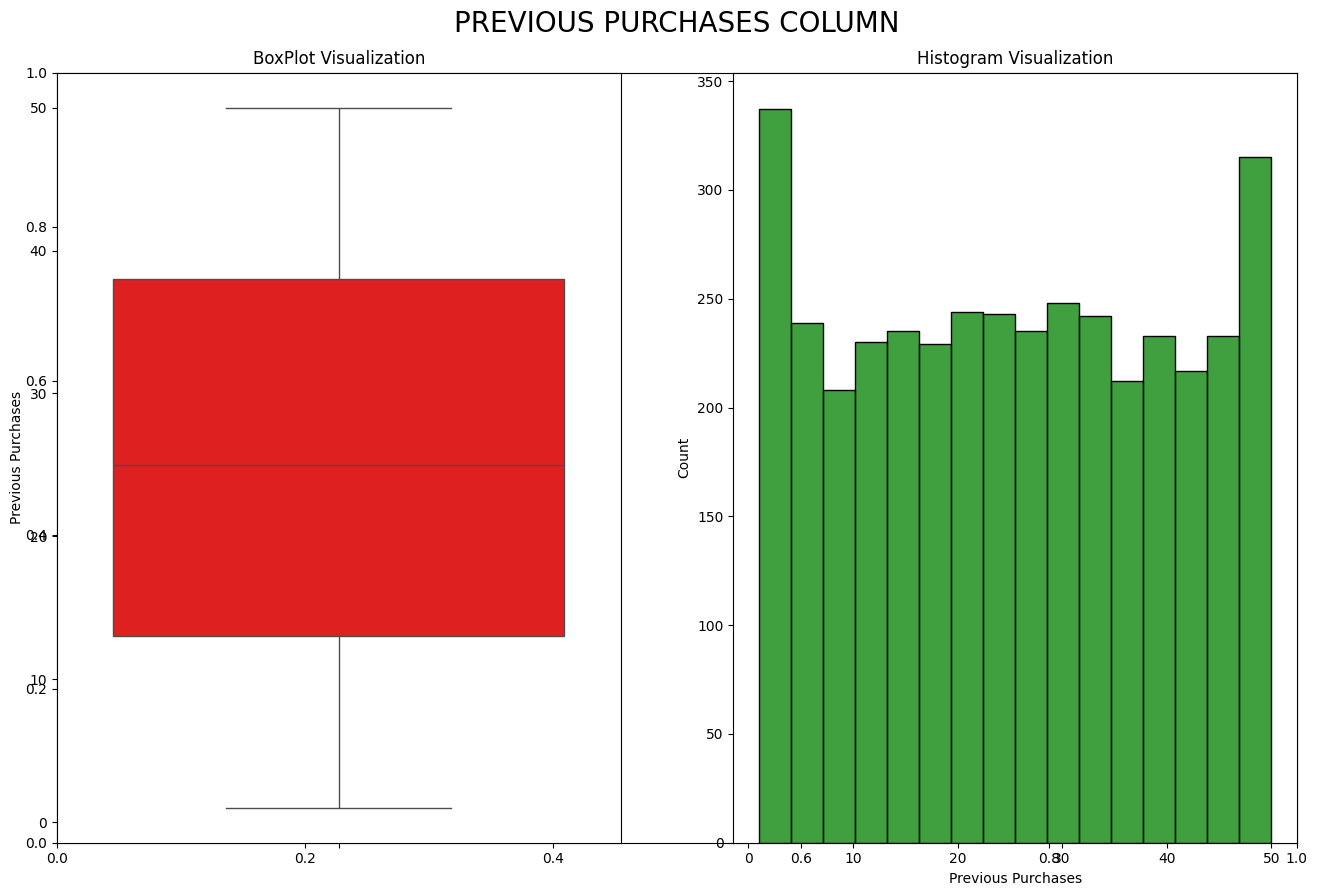

In [284]:
for column in numerical:
  plt.figure(figsize = (16,10))

  plt.title(f"{column.upper()} COLUMN\n", size = 20)

  plt.subplot(1,2,1)
  sns.boxplot(df2[column], color = 'Red')
  plt.title(f"BoxPlot Visualization")

  plt.subplot(1,2,2)
  sns.histplot(df2[column], color = 'Green')
  plt.title(f"Histogram Visualization")

  plt.show()

From the visualization above, we know that the data is normally distributed based on the histogram, and also we can identify that there are no outliers at all the numerical categories from the dataset based on the boxplot, so there is no needed any further action through the outlier

### II.1.2. Data Preparation : Anomaly Categorical Values Identification and Treatment

Before we are going to the categorical unique values identification, we will remove the **Birth date** and **Customer ID** column because it has no correlation with the model deployment later on.

* Birth date : The data of customer's birth date has no correlation with the customer purchasement behavior  
* Customer ID : This is a unique identifier which all its values are unique, and has no correlation with the model

In [285]:
df2 = df2.drop(columns = ['Customer ID', 'Birth Date'])

# Redefined the numerical and categorical variable because some of them has been deleted
numerical = df2.select_dtypes(include = ['number'])
categorical = df2.select_dtypes(include = ['object'])

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Gender                    3900 non-null   object 
 1   Item Purchased            3900 non-null   object 
 2   Category                  3900 non-null   object 
 3   Purchase Amount (USD)     3900 non-null   int64  
 4   Location                  3900 non-null   object 
 5   Size                      3900 non-null   object 
 6   Color                     3900 non-null   object 
 7   Season                    3900 non-null   object 
 8   Review Rating             3900 non-null   float64
 9   Subscription Status       3900 non-null   object 
 10  Payment Method            3900 non-null   object 
 11  Shipping Type             3900 non-null   object 
 12  Discount Applied          3900 non-null   object 
 13  Promo Code Used           3900 non-null   object 
 14  Previous

In [286]:
categorical = df2.select_dtypes(include = ['object'])

for column in categorical:
  print('Column', column, 'Value Counts:')
  print(df2[column].value_counts())
  print('===========================\n')

Column Gender Value Counts:
Gender
Male      2642
Female    1231
f           17
M           10
Name: count, dtype: int64

Column Item Purchased Value Counts:
Item Purchased
Blouse        171
Jewelry       171
Pants         171
Shirt         169
Dress         166
Sweater       164
Jacket        163
Belt          161
Sunglasses    161
Coat          161
Sandals       160
Socks         159
Skirt         158
Shorts        157
Scarf         157
Hat           154
Handbag       153
Hoodie        151
Shoes         150
T-shirt       147
Sneakers      145
Boots         144
Backpack      143
Gloves        140
Jeans         124
Name: count, dtype: int64

Column Category Value Counts:
Category
Clothing       1737
Accessories    1240
Footwear        599
Outerwear       324
Name: count, dtype: int64

Column Location Value Counts:
Location
Montana           96
California        95
Idaho             93
Illinois          92
Alabama           89
Minnesota         88
Nebraska          87
New York          

On the **gender** column, there are some **anomalies value**, which consists of male, female, M and f, so we will fix it first.

In [287]:
df2['Gender'][df2['Gender'] == 'f'] = 'Female'
df2['Gender'][df2['Gender']=='M'] = 'Male'
df2['Gender'].value_counts()

Gender
Male      2652
Female    1248
Name: count, dtype: int64

And with that, our data has already been consistent.

### II.1.3. Exploratory Data Analysis

Firstly, we will explore the distribution of each NUMERICAL variable with the histogram plot

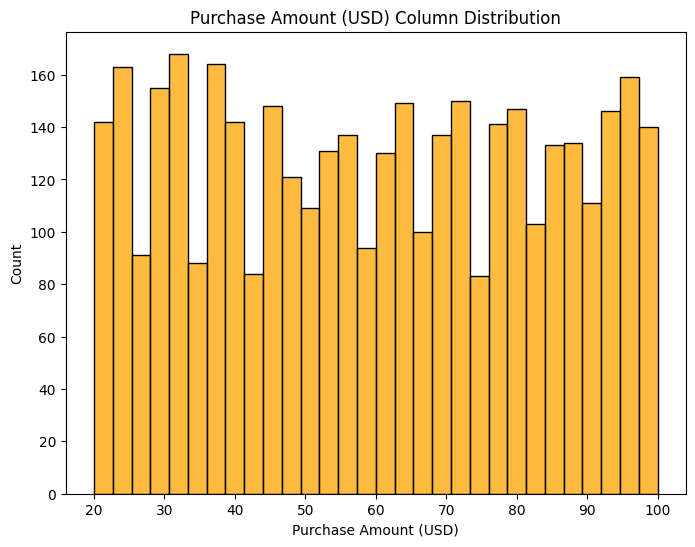


Kolmogorov-Smirnov Normality Test:
P-Value: 0.0 
Statistic Value: 1.0 




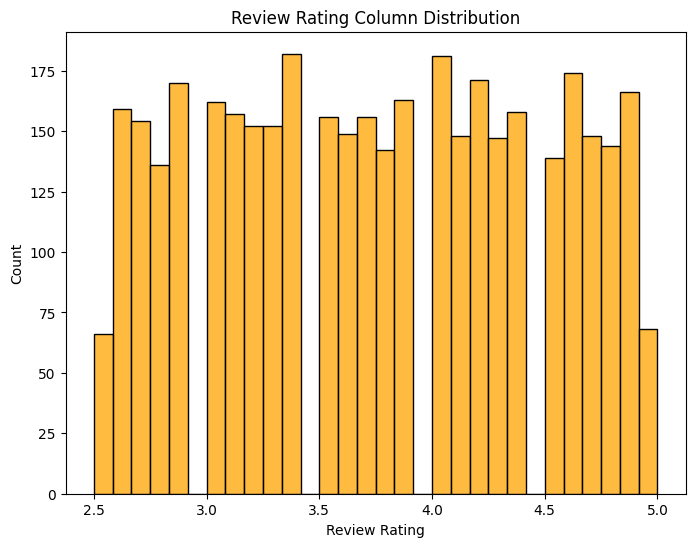


Kolmogorov-Smirnov Normality Test:
P-Value: 0.0 
Statistic Value: 0.9937903346742238 




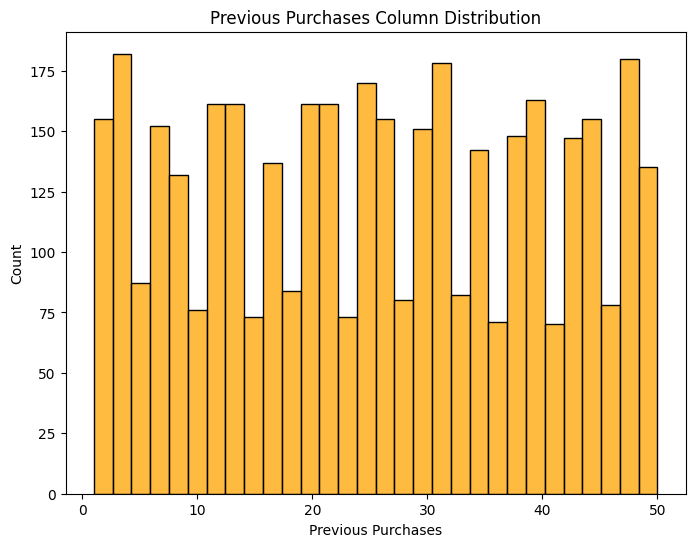


Kolmogorov-Smirnov Normality Test:
P-Value: 0.0 
Statistic Value: 0.9589065122247802 




In [288]:
for column in numerical:
  plt.figure(figsize = (8,6))
  sns.histplot(df2[column], bins = 30, color = 'Orange')
  plt.title(f"{column} Column Distribution")
  plt.show()

  stat, pval = kstest(df2[column], 'norm')
  print('\nKolmogorov-Smirnov Normality Test:\nP-Value:',pval,'\nStatistic Value:',stat, '\n\n')

From the visualization above, we can see the data is not well and normally distributed at all.  
Based on the Kolmogorov-Smirnov Test, that based on the normal distribution, we can see that mostly of the numerical variables are results this:  
* 0.0 value for the P-Value, means that it is not normally distributed, because a data can be concluded has normally distributed once the P-Value > 0.5
* For the statistical value, almost all column is near to 1, it means that the data's distribution are not following the distribution type that we are evaluating, which is normal distribution.

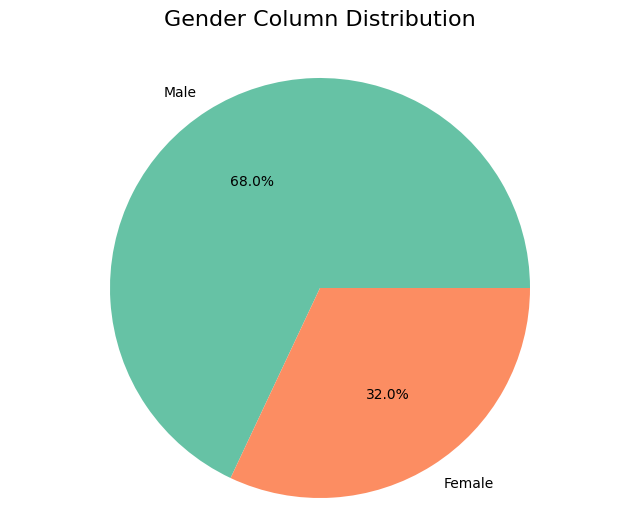

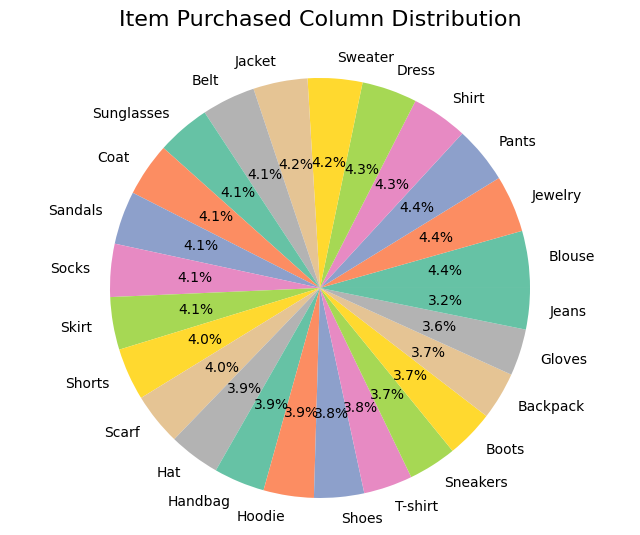

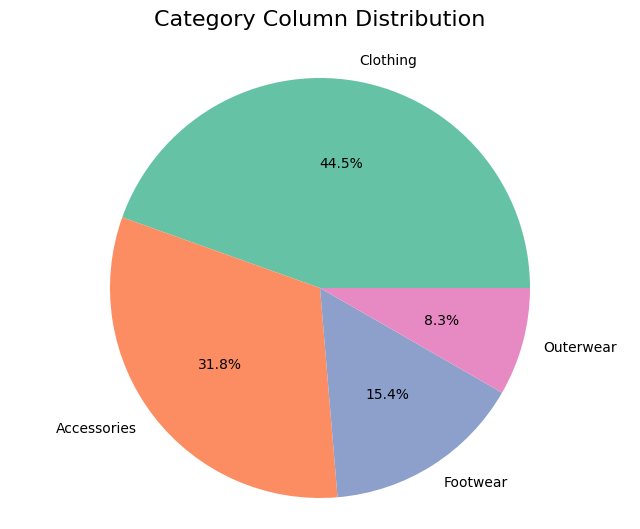

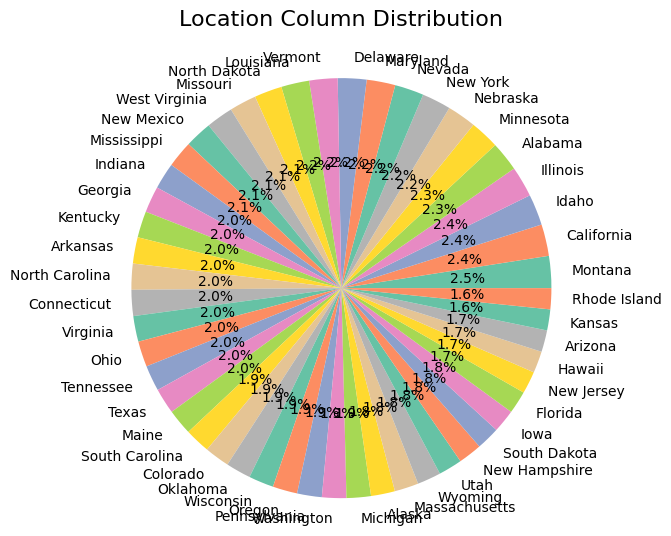

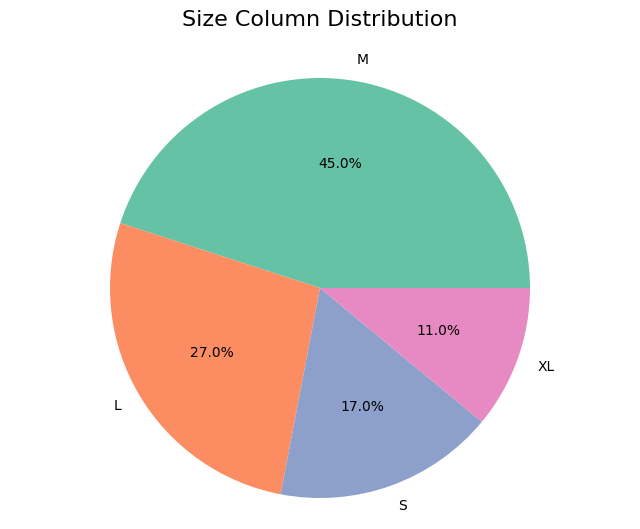

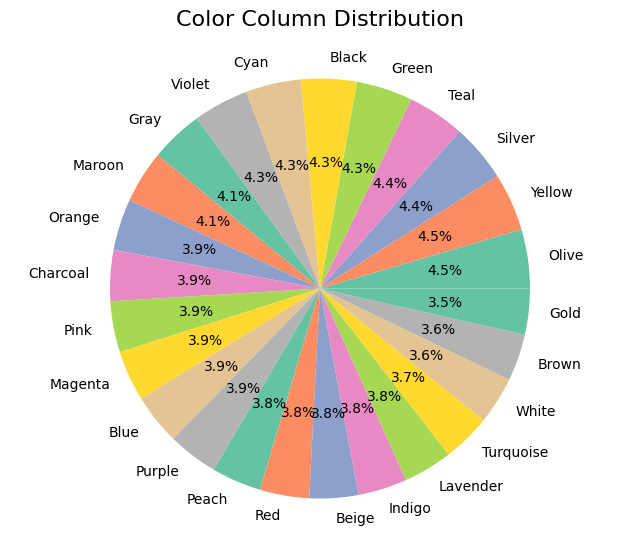

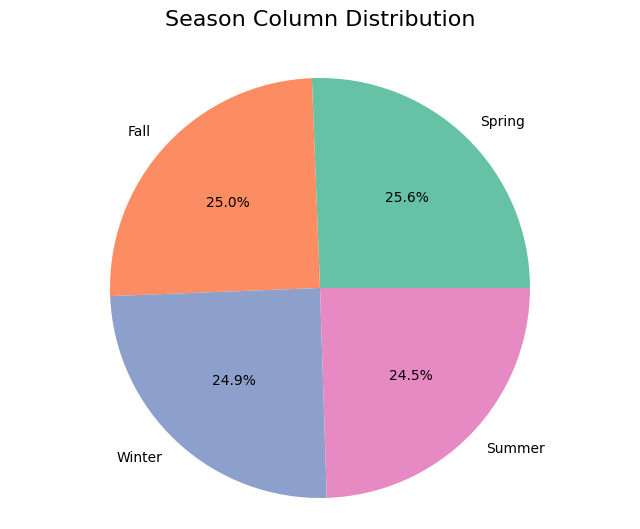

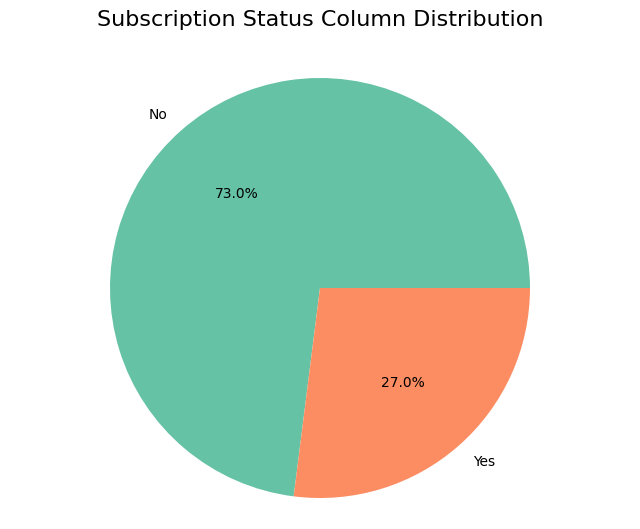

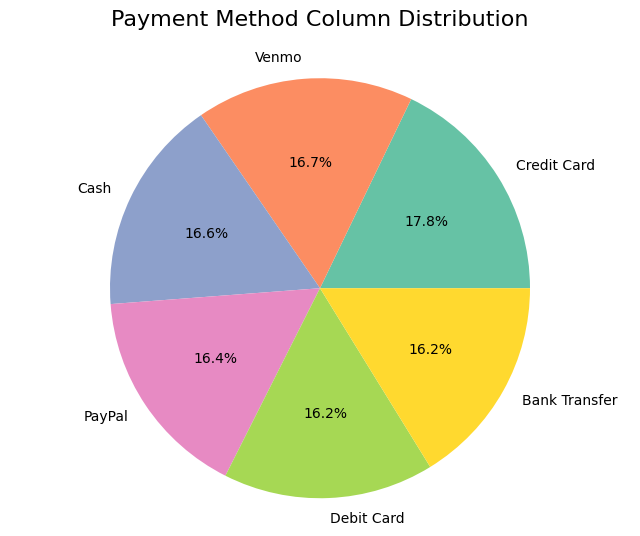

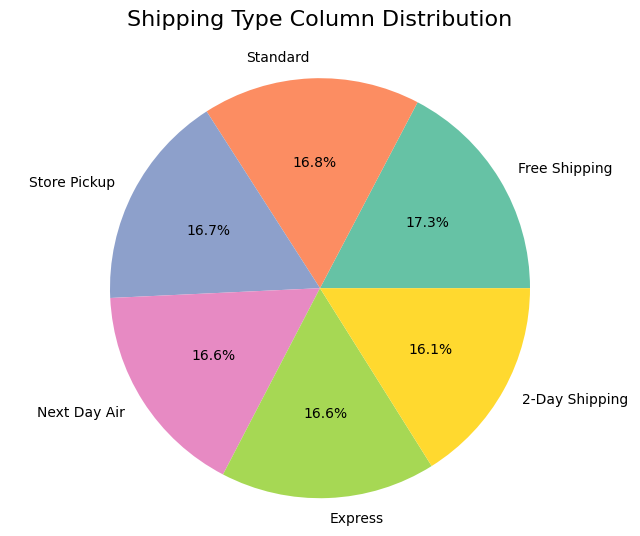

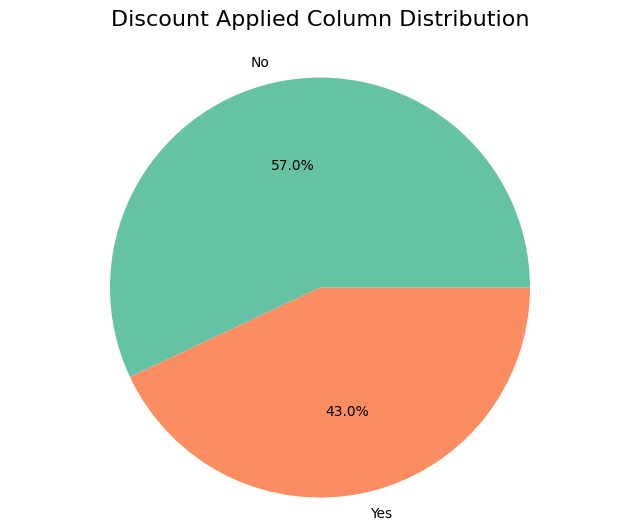

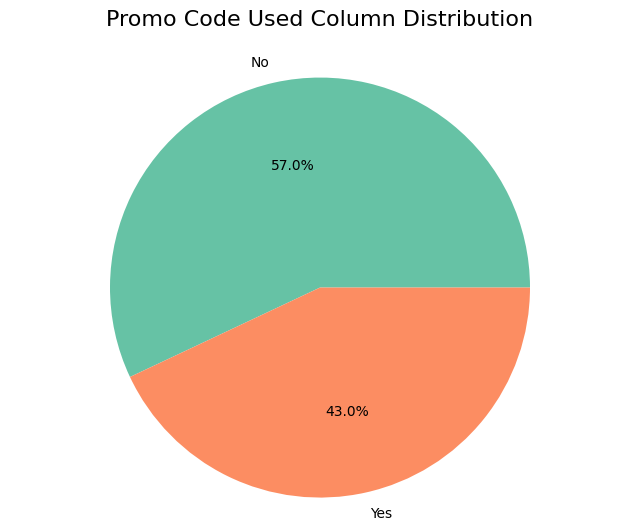

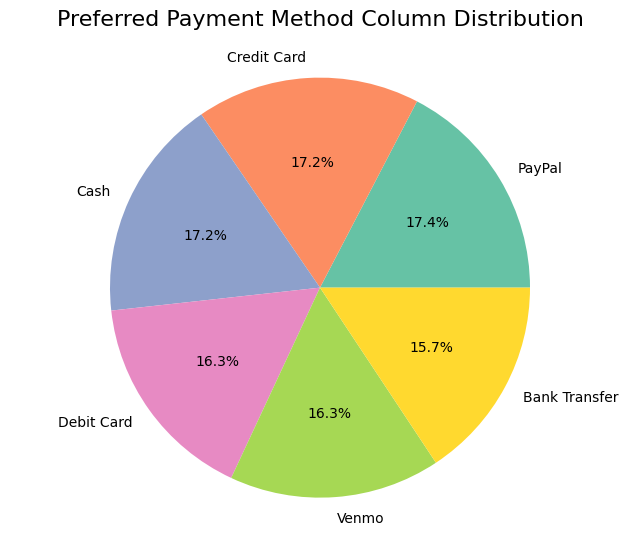

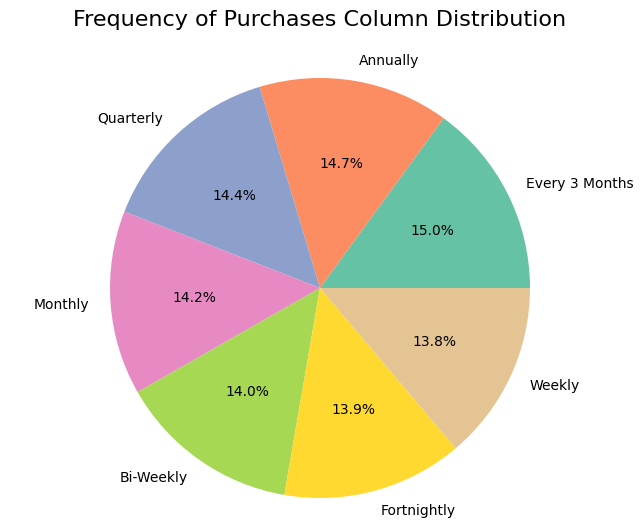

In [289]:
for column in categorical:
  valueCount = df2[column].value_counts()
  plt.figure(figsize=(8,6))
  plt.pie(valueCount, labels = valueCount.index, autopct = '%1.1f%%', colors = sns.color_palette("Set2", len(valueCount)))
  plt.axis('equal')
  plt.title(f"{column} Column Distribution\n", size = 16)
  plt.show()

From the visualization of categorical values distribution above, we can group that distribution values to three different kinds between each category based on its difference from the maximum percentage to the minimum:  
* High-Well Distributed (5% difference), this is for the best distribution which has the approximate count values between one values to the others. We can find this distribution on the Item Purchased, Location, Column, Season, Payment Method, Shipping Type, Preferred Payment, Frequency Purchases columns
* Middle-Well Distributed (15% difference), this is for the distribution that has not to far distribution value percentage between one to the others. We can find theese on Discount Applied, Promo Code columns
* Poor Distributed (>15% difference), this is for the distribution that has high difference on values occurence between the one to others. We can find on the Gender, Category, Size, Subscription Status columns
  
Even though there are more columns that has high-well distributed, but the core and important categories that we will use for clustering has the poor distribution, so it may be the disadvantages through the model that we will build later on.

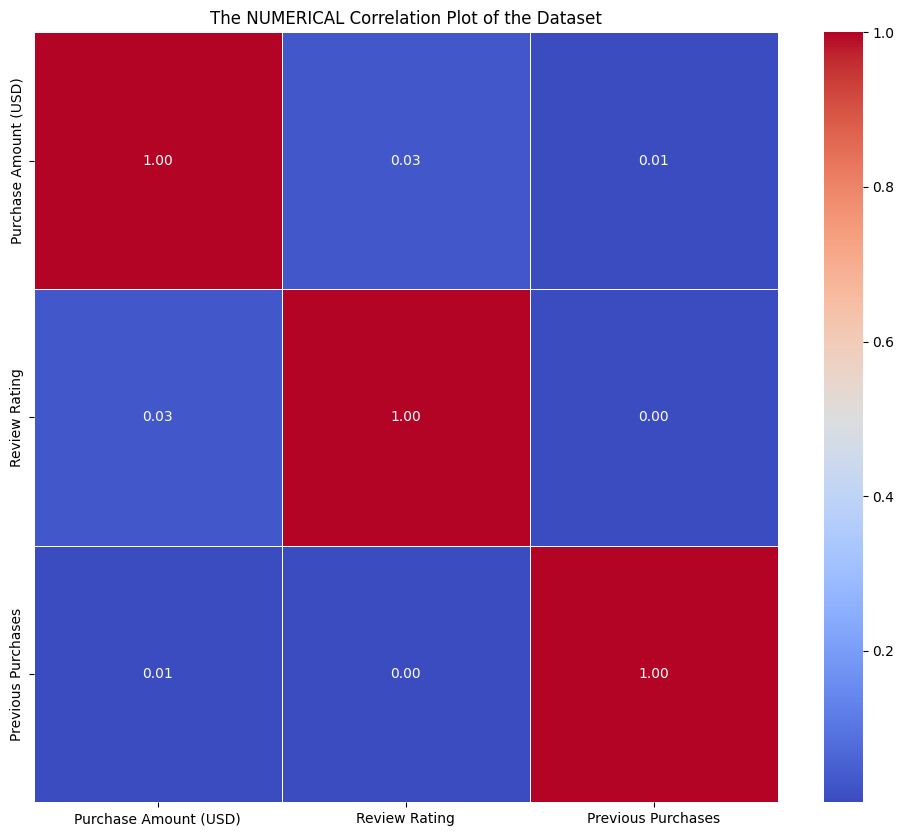

In [290]:
corMatrix = numerical.corr()

plt.figure(figsize = (12,10))
sns.heatmap(corMatrix, annot = True, cmap = "coolwarm", fmt = ".2f", linewidths = 0.5)
plt.title("The NUMERICAL Correlation Plot of the Dataset")
plt.show()

Based on the correlation plot above, we can see that the numerical variable has no correlation at all to the other. This may compound the model to learn and find the pattern from the numerical variable as it is has no correlation

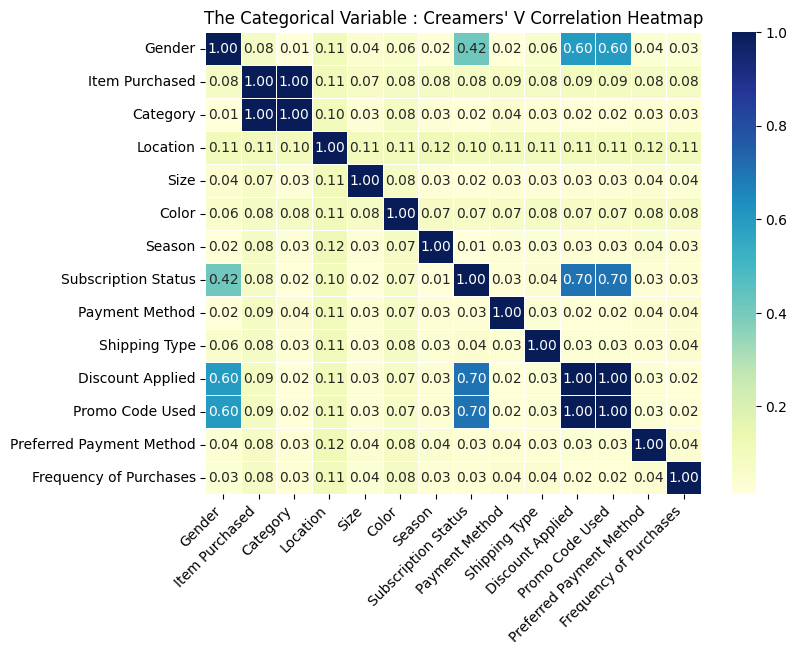

In [291]:
Matrix = pd.DataFrame(index = categorical.columns, columns = categorical.columns)

for column1 in categorical:
  for column2 in categorical:
    if column1 == column2:
      Matrix.loc[column1, column2] = 1 #This indicates the perfect correlation with theirselves
    else:
      contingencyTable = pd.crosstab(df2[column1], df2[column2])
      chi2, _, _, _ = chi2_contingency(contingencyTable)
      n = contingencyTable.sum().sum()
      r, k = contingencyTable.shape
      Matrix.loc[column1, column2] = np.sqrt(chi2 / (n*(min(r,k) - 1)))

Matrix = Matrix.astype(float)

plt.figure(figsize=(8,6))
sns.heatmap(Matrix, annot = True, fmt = '.2f', cmap = 'YlGnBu', linewidths = 0.5)
plt.xticks(rotation=45, ha='right')  # Putar label sumbu x
plt.yticks(rotation=0)   
plt.title("The Categorical Variable : Creamers' V Correlation Heatmap")
plt.show()

Based on the creamers' v that shows the categorical correlation, we can see that only few variables that has correlation with the others : subscription status with gender, subscription status with promo code used, etc. Most of the variables are not correlated each other, and same like numerical, it may become the disadvantages for the model to learn the pattern from the dataset that has less correlation between the variables.

### II.1.4. Feature Enginering Categorical Variables

Because we are going to build a model, so we need to convert the string categorical variables into a numerical one to ease the learning of the model. The type of encoding will be based on the value from the each variabel.

In [292]:
for column in categorical:
  print('Column', column, 'Value Counts:')
  print(df2[column].value_counts())
  print('===========================\n')

Column Gender Value Counts:
Gender
Male      2652
Female    1248
Name: count, dtype: int64

Column Item Purchased Value Counts:
Item Purchased
Blouse        171
Jewelry       171
Pants         171
Shirt         169
Dress         166
Sweater       164
Jacket        163
Belt          161
Sunglasses    161
Coat          161
Sandals       160
Socks         159
Skirt         158
Shorts        157
Scarf         157
Hat           154
Handbag       153
Hoodie        151
Shoes         150
T-shirt       147
Sneakers      145
Boots         144
Backpack      143
Gloves        140
Jeans         124
Name: count, dtype: int64

Column Category Value Counts:
Category
Clothing       1737
Accessories    1240
Footwear        599
Outerwear       324
Name: count, dtype: int64

Column Location Value Counts:
Location
Montana           96
California        95
Idaho             93
Illinois          92
Alabama           89
Minnesota         88
Nebraska          87
New York          87
Nevada            87
Maryla

From the type of each column's values above, we will use three kind of feature engineering, which consists of :    
1. Binary encoding, to convert the string to a binary integer in the same column, we will use it for the Subscription Status, Discount Applied, and Promo Code Used columns, which means : 1 is yes/true, and 0 is no/false
2. One Hot Encoding, to convert the string to a new column that named the value of that string, we will use it for Gender, Item Purchased, Category, Location, Color, Season, Payment Method, Shipping Type, Preferred Payment Method, Frequency of Purchases, to specify the name of the value and avoid misconception
3. Label Encoding, to convert the ordinal string. We will use it to the Size, because S, M, L and XL shows the level of size.

In [293]:
# Binary Encoding
df2_encode = {"Subscription Status" : {"Yes" : 1, "No" : 0}, "Promo Code Used" : {"Yes" : 1, "No" : 0}, "Discount Applied" : {"Yes" : 1, "No" : 0}}
df2 = df2.replace(df2_encode)
df2[["Subscription Status", "Promo Code Used", "Discount Applied"]].head(5)

,Subscription Status,Promo Code Used,Discount Applied
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1


In [294]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Gender                    3900 non-null   object 
 1   Item Purchased            3900 non-null   object 
 2   Category                  3900 non-null   object 
 3   Purchase Amount (USD)     3900 non-null   int64  
 4   Location                  3900 non-null   object 
 5   Size                      3900 non-null   object 
 6   Color                     3900 non-null   object 
 7   Season                    3900 non-null   object 
 8   Review Rating             3900 non-null   float64
 9   Subscription Status       3900 non-null   int64  
 10  Payment Method            3900 non-null   object 
 11  Shipping Type             3900 non-null   object 
 12  Discount Applied          3900 non-null   int64  
 13  Promo Code Used           3900 non-null   int64  
 14  Previous

In [295]:
# One Hot Encoding
enc = OneHotEncoder()
df2_encode = pd.DataFrame(enc.fit_transform(df2[['Gender']]).toarray(), columns = enc.get_feature_names_out())
df2_encode2 =pd.DataFrame(enc.fit_transform(df2[['Item Purchased']]).toarray(), columns = enc.get_feature_names_out())
df2_encode3 =pd.DataFrame(enc.fit_transform(df2[['Category']]).toarray(), columns = enc.get_feature_names_out())
df2_encode4 =pd.DataFrame(enc.fit_transform(df2[['Location']]).toarray(), columns = enc.get_feature_names_out())
df2_encode5 =pd.DataFrame(enc.fit_transform(df2[['Color']]).toarray(), columns = enc.get_feature_names_out())
df2_encode6 =pd.DataFrame(enc.fit_transform(df2[['Season']]).toarray(), columns = enc.get_feature_names_out())
df2_encode7 =pd.DataFrame(enc.fit_transform(df2[['Payment Method']]).toarray(), columns = enc.get_feature_names_out())
df2_encode8 =pd.DataFrame(enc.fit_transform(df2[['Shipping Type']]).toarray(), columns = enc.get_feature_names_out())
df2_encode9 =pd.DataFrame(enc.fit_transform(df2[['Preferred Payment Method']]).toarray(), columns = enc.get_feature_names_out())
df2_encode10 =pd.DataFrame(enc.fit_transform(df2[['Frequency of Purchases']]).toarray(), columns = enc.get_feature_names_out())
df2 = df2.reset_index()
df2 = pd.concat([df2, df2_encode, df2_encode2,df2_encode3,df2_encode4,df2_encode5,df2_encode6,df2_encode7,df2_encode8,df2_encode9,df2_encode10], axis = 1)
df2.head()

,index,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,...,Preferred Payment Method_Debit Card,Preferred Payment Method_PayPal,Preferred Payment Method_Venmo,Frequency of Purchases_Annually,Frequency of Purchases_Bi-Weekly,Frequency of Purchases_Every 3 Months,Frequency of Purchases_Fortnightly,Frequency of Purchases_Monthly,Frequency of Purchases_Quarterly,Frequency of Purchases_Weekly
0,0,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [296]:
# Label Encoding
labelEncoder = LabelEncoder()
labelEncoder.fit(['XL','L','M','S'])
df2['Size'] = labelEncoder.transform(df2['Size'])
df2['Size'].head(5)

0    0
1    0
2    2
3    1
4    1
Name: Size, dtype: int32

### II.1.6. Data Normalization

Next, we will normalize the data, which manipulate the numerical variable so it has only the small range of data and uniform it with the other numerical variable. It aims to increase the accuracy of learning rate of the model.  
Because of the numerical data has no outlier at all, so we will use the z-score normalization method to normalize it because it is sensitive with the outlier but has the best recommendation fit.

In [297]:
scaler = StandardScaler()

for column in numerical:
    df2[column] = scaler.fit_transform(df2[[column]])

In [298]:
df2[['Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']]

,Purchase Amount (USD),Review Rating,Previous Purchases
0,-0.285629,-0.907584,-0.785831
1,0.178852,-0.907584,-1.616552
2,0.558882,-0.907584,-0.162789
3,1.276716,-0.349027,1.637107
4,-0.454531,-1.466141,0.391025
...,...,...,...
3895,-1.341267,0.628448,0.460252
3896,-0.454531,1.047366,1.083293
3897,-1.130139,-1.186862,-0.093563
3898,0.727784,0.069891,-0.093563


### II.1.6. Final Checking before Modelling

In [299]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Columns: 153 entries, index to Frequency of Purchases_Weekly
dtypes: float64(138), int32(1), int64(4), object(10)
memory usage: 4.5+ MB


Based on the information above, there are still 10 columns that categorized as the object dataset and it will not be working with the model itself. These columns are original categorical column that has been encoded (with one hot encoder), so it is a remainder columns that we can drop these features.  


So, we will drop the residual columns that has been encoded at the other columns

In [300]:
categoricalList = df2.select_dtypes(include=['object']).columns.tolist()
df2 = df2.drop(columns = categoricalList)
df2 = df2.drop(columns = ['index'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Columns: 142 entries, Purchase Amount (USD) to Frequency of Purchases_Weekly
dtypes: float64(138), int32(1), int64(3)
memory usage: 4.2 MB


And when all of the columns has the numerical datatype, then it means that our dataset has ready for the clustering modeling.

## II.2. Train K-Means Clustering Model

At this part, we will training a data with some models based on the clustering, because the data still doesnt have the output label, using the K-Means Model, and tuning the hyperparameters to fit the best one to its accuracy level.

### II.2.1. PCA Transformation

Before we are going to the model deployment, first we will do the Principal Component Analysis (PCA) first to the number of main components that we want to stay in the analysis and model.

First, we will observe the best number of components on PCA by the variance value that we want to maintained, which is 95% of variance.

In [301]:
pca = PCA()
pca.fit(df2)

explainedVarianceRatio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explainedVarianceRatio)
nComponents = np.argmax(cumulative_variance >= 0.95) + 1
print('The number of PCA Components will be',nComponents)

The number of PCA Components will be 94


In [302]:
pca2 = PCA(n_components = nComponents)
reducedDf = pca.fit_transform(df2)

reducedDf

array([[ 1.18373169e+00,  3.40292865e-01, -4.13636411e-01, ...,
         1.37865128e-16,  3.89821382e-16, -2.02246688e-16],
       [ 9.88522917e-01,  1.18096448e+00, -7.09127809e-01, ...,
         3.52189261e-17,  1.98026664e-16, -6.74572811e-17],
       [ 1.38471084e-01,  3.47686924e-02, -9.63414967e-01, ...,
         4.07892243e-17,  9.80738623e-17, -4.38895575e-16],
       ...,
       [ 1.74725406e+00, -2.52517775e-02, -8.82097827e-02, ...,
         1.97151000e-17,  1.00047482e-17,  3.23151553e-17],
       [-7.35506281e-01,  4.19265755e-01, -4.83478368e-01, ...,
         1.60634040e-17, -2.23434344e-17,  4.22606287e-17],
       [-9.94184190e-02, -3.64703884e-01, -1.29689542e+00, ...,
         4.19760988e-17, -9.66354522e-17,  4.74421147e-17]])

### II.2.2. Build the Model with N Cluster-Tuning

In [303]:
n_Cluster = []
silhouette = []
inertia = []

for n in range(2,13):
    kmeanModel = KMeans(n_clusters = n, random_state = 42)
    predictCluster = kmeanModel.fit_predict(reducedDf)

    silhouetteScore = 0
    inertiaScore = 0

    n_Cluster.append(n)
    silhouetteScore = silhouette_score(reducedDf, predictCluster)
    silhouette.append(silhouetteScore)
    inertiaScore = kmeanModel.inertia_
    inertia.append(inertiaScore)
    

### II.2.3. Find the Best K-Means Accuracy

Text(0.5, 1.0, 'Average Silhouette Score Comparison on K-Value Tuning')

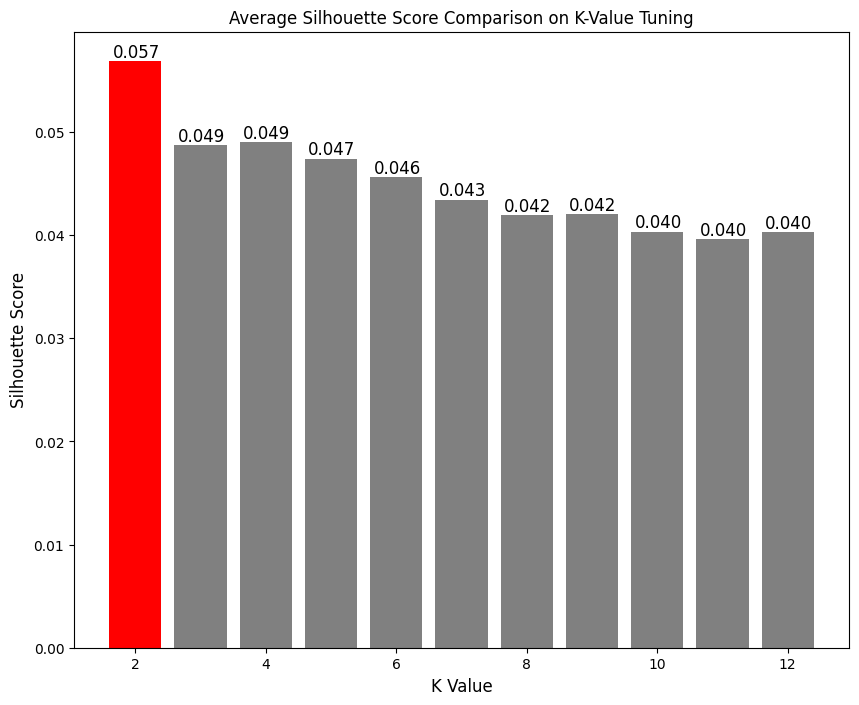

In [310]:
plt.figure(figsize = (10,8))
colors = ['red' if value == max(silhouette) else 'gray' for value in silhouette]
bar = plt.bar(n_Cluster, silhouette, color = colors)
plt.xlabel("K Value", size = 12)
plt.ylabel("Silhouette Score", size = 12)
for bar, value in zip(bar, silhouette):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.35, bar.get_height(), f"{value:.3f}", ha='left', va='bottom', fontsize = 12)
plt.title("Average Silhouette Score Comparison on K-Value Tuning")

Based on that visualization, we can interpret that the best average silhouette score is located on the 2 clusters.

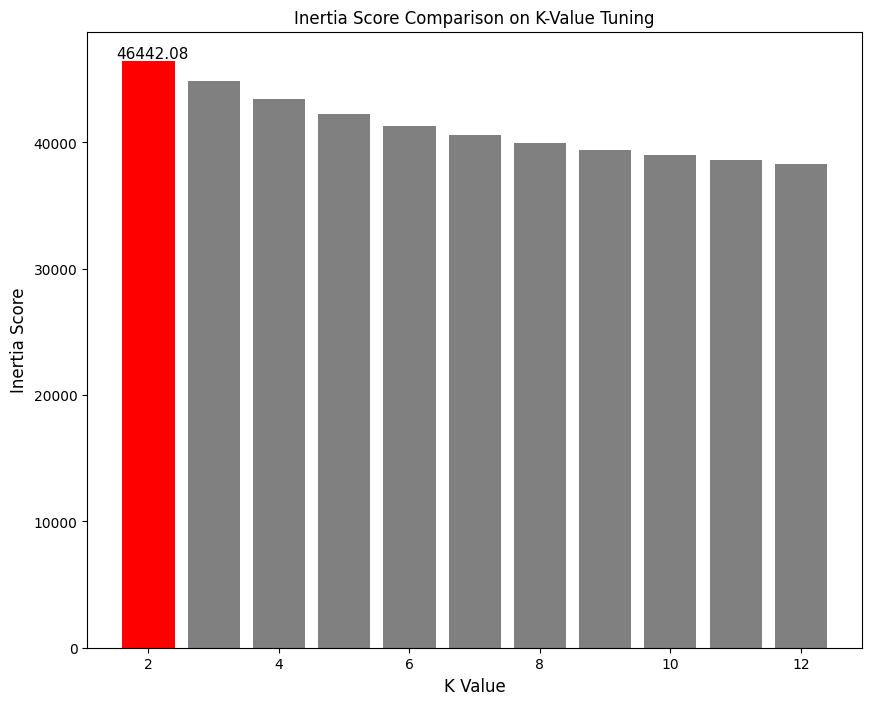

In [312]:
plt.figure(figsize = (10,8))
colors = ['red' if value == max(inertia) else 'gray' for value in inertia]
bar = plt.bar(n_Cluster, inertia, color = colors)
plt.xlabel("K Value", size = 12)
plt.ylabel("Inertia Score", size = 12)
for bar, value in zip(bar, inertia):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.5, bar.get_height()+1, f"{value:.2f}", ha='left', va='bottom', fontsize = 11)
    break
plt.title("Inertia Score Comparison on K-Value Tuning")
plt.show()

Based on the visualization, we can also interpret that the best inertia score is located on the 2 clusters.

### II.2.4. Fit the Best K Model

Based on the evaluation from the silhouette and inertia score, then we can know that the best evaluation score is located on the experience that using the number of 2 clusters. So, the best parameter that we will use for the kmeans model is 2 as the effort to find the best suited model.

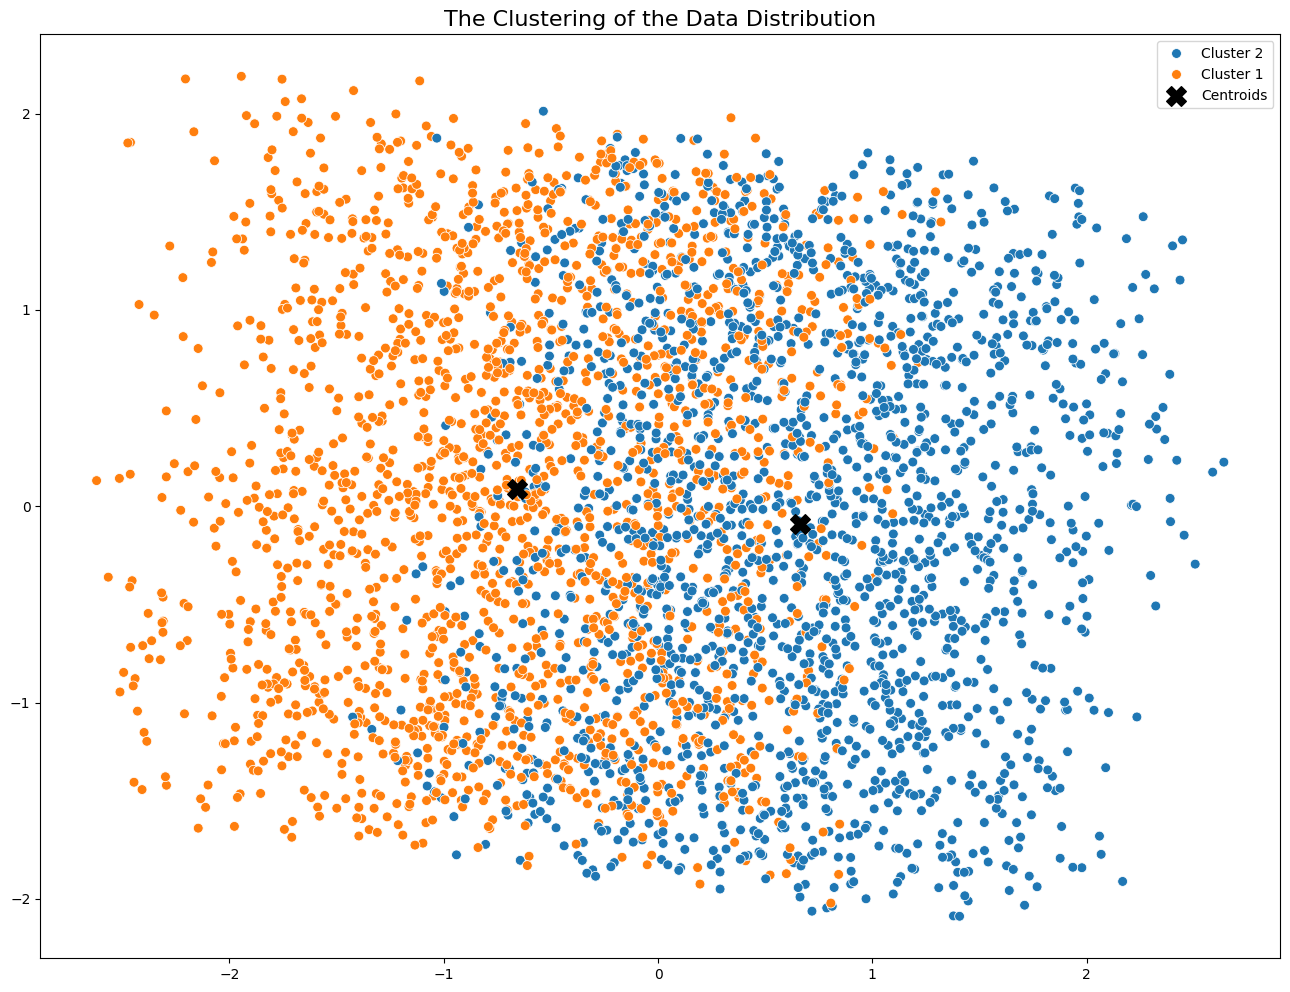

In [322]:
kmeans = KMeans(n_clusters = 2, random_state = 42)
df2['cluster'] = kmeans.fit_predict(reducedDf)
modelLabel = {0:"Cluster 1",1:"Cluster 2"}
df2['cluster'] = df2['cluster'].map(modelLabel)

plt.figure(figsize=(16,12))
sns.scatterplot(x=reducedDf[:,0], y=reducedDf[:,1], hue = df2['cluster'], s = 50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s=200, c='black', label='Centroids', marker='X')
plt.title("The Clustering of the Data Distribution", size = 16)
plt.legend()

## II.3. Characteristics of Each Customer Cluster

Before we are going to analyze the each characteristics of customer from each cluster (that divided into first-cluster and the second-cluster), then we will filter first the features that has good variance on the data distribution to ease the characteristic allocation. We will use the 0.1 variance value as the standard and threshold of good variance of a column.

In [307]:
varianceFilter = VarianceThreshold(threshold = 0.1)
features = df2.drop(columns = ['cluster'])
selectedFeatures = varianceFilter.fit_transform(features)
selectedColumns = features.columns[varianceFilter.get_support()]
selectedColumns

Index(['Purchase Amount (USD)', 'Size', 'Review Rating', 'Subscription Status',
       'Discount Applied', 'Promo Code Used', 'Previous Purchases',
       'Gender_Female', 'Gender_Male', 'Category_Accessories',
       'Category_Clothing', 'Category_Footwear', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Payment Method_Bank Transfer', 'Payment Method_Cash',
       'Payment Method_Credit Card', 'Payment Method_Debit Card',
       'Payment Method_PayPal', 'Payment Method_Venmo',
       'Shipping Type_2-Day Shipping', 'Shipping Type_Express',
       'Shipping Type_Free Shipping', 'Shipping Type_Next Day Air',
       'Shipping Type_Standard', 'Shipping Type_Store Pickup',
       'Preferred Payment Method_Bank Transfer',
       'Preferred Payment Method_Cash', 'Preferred Payment Method_Credit Card',
       'Preferred Payment Method_Debit Card',
       'Preferred Payment Method_PayPal', 'Preferred Payment Method_Venmo',
       'Frequency of Purchases_Annual

Then, we will explore the distribution between the values on a column that has the distribution on the 1st and 2nd cluster with the boxplot visualization

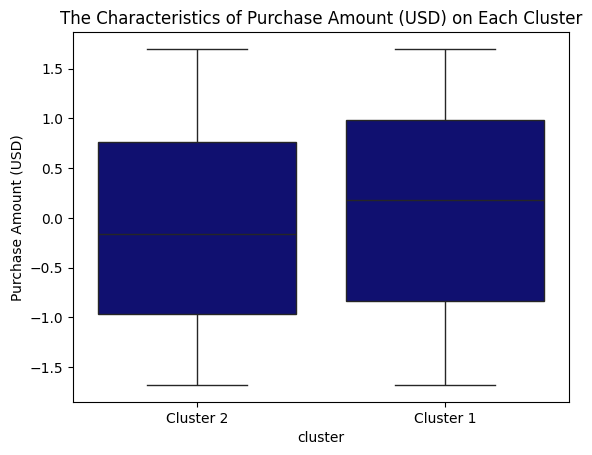

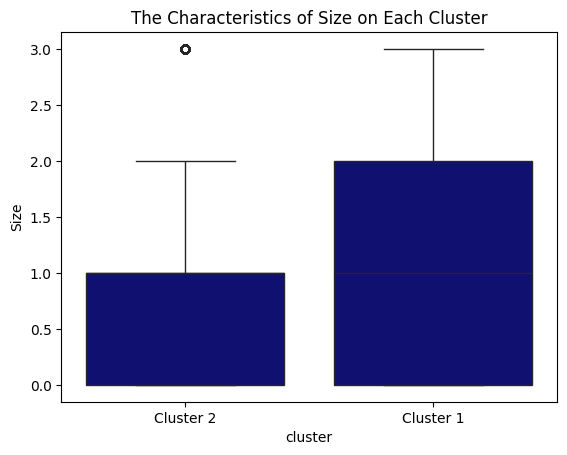

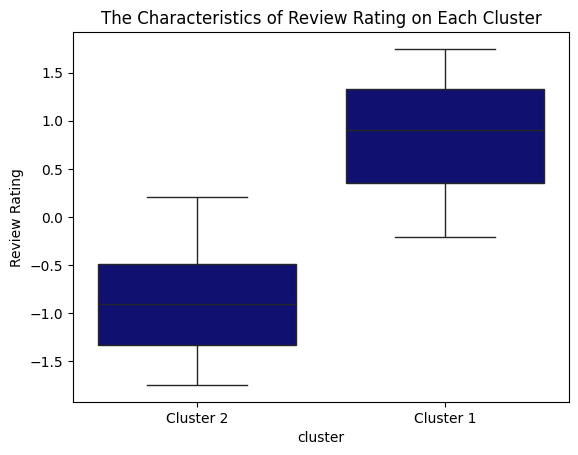

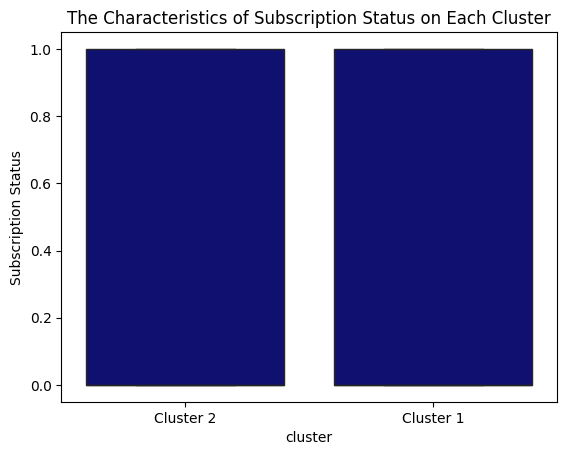

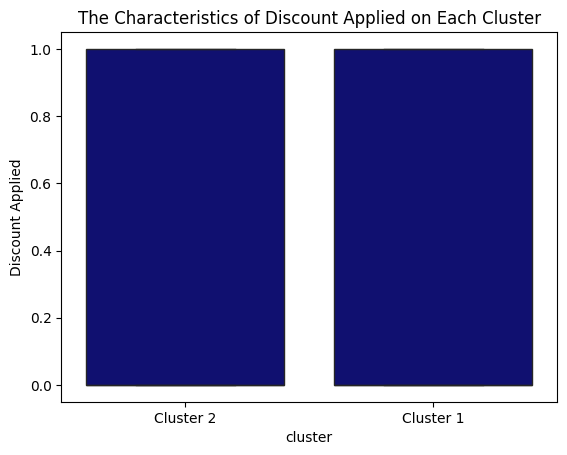

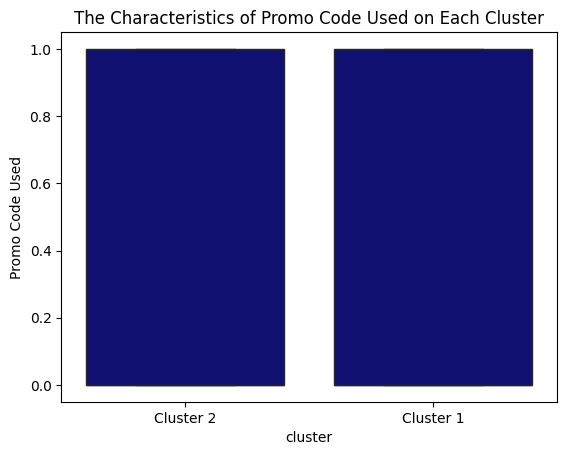

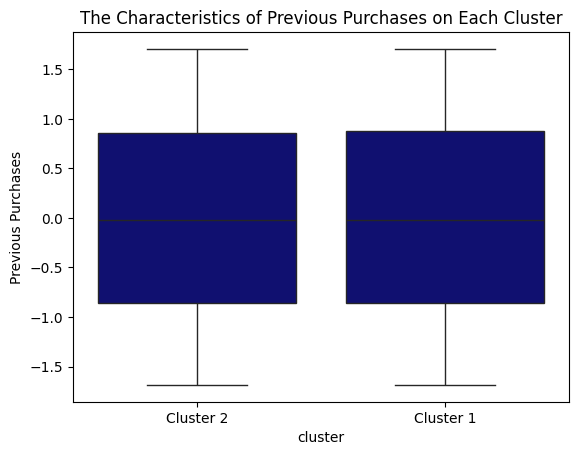

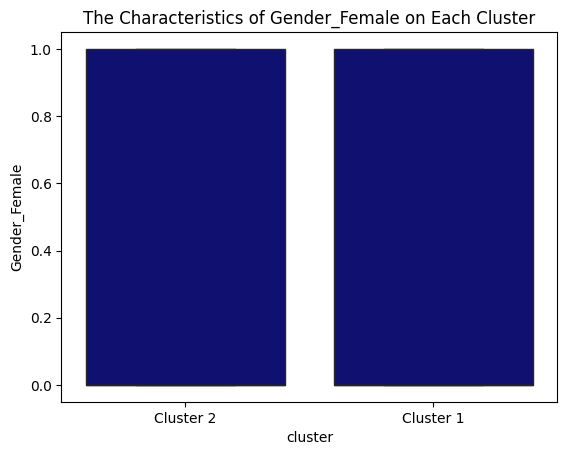

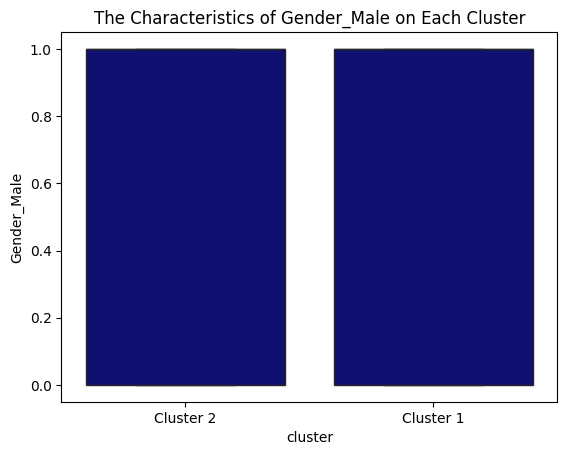

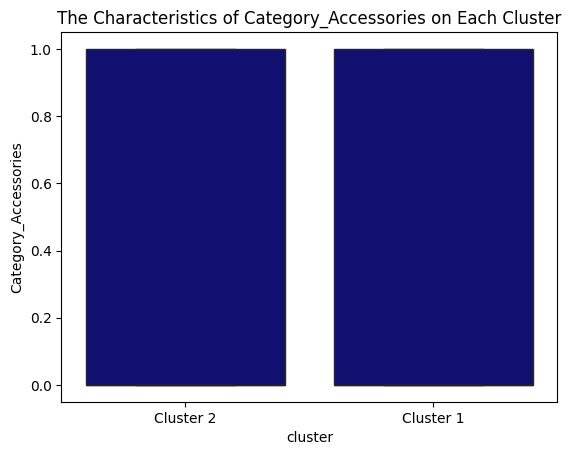

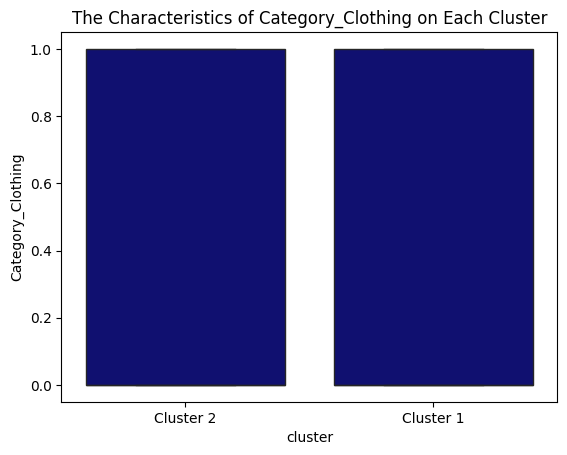

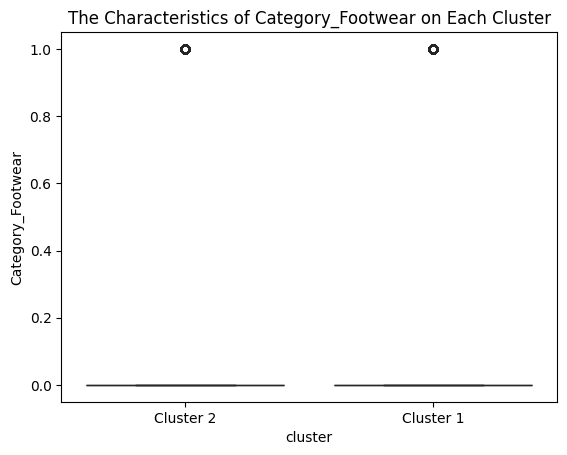

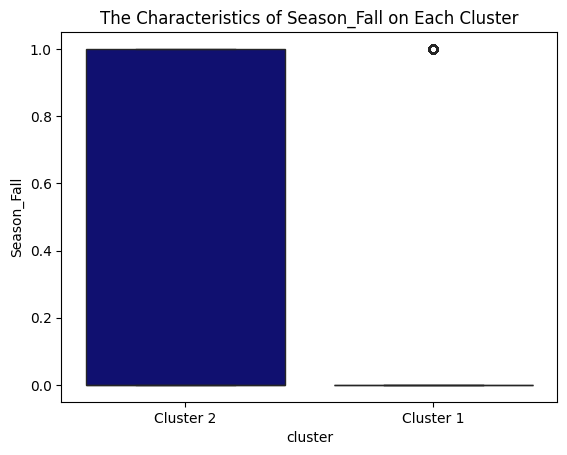

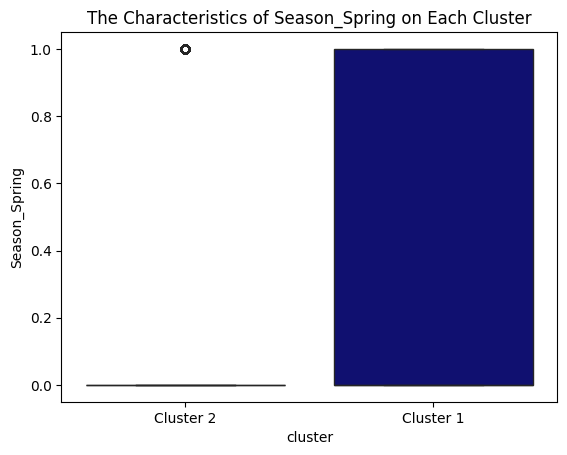

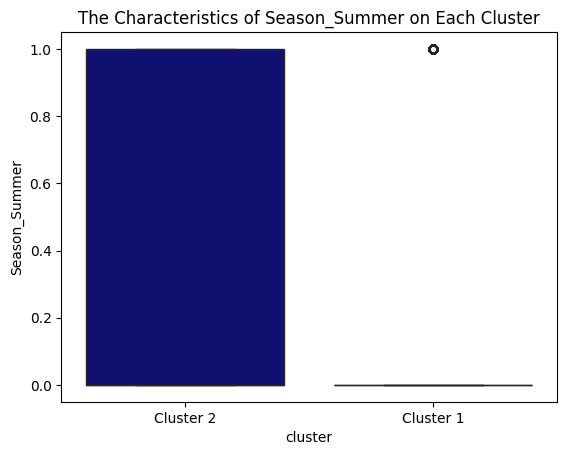

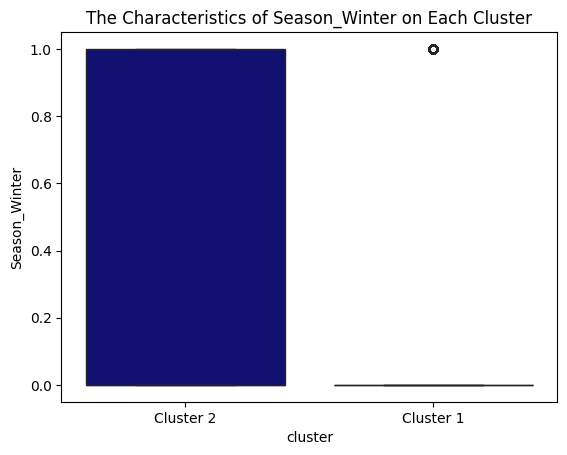

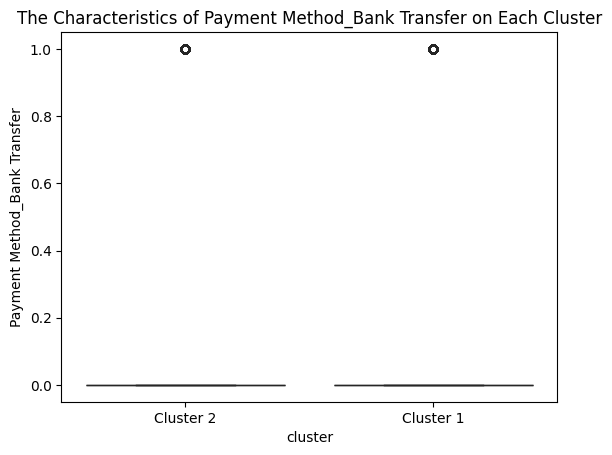

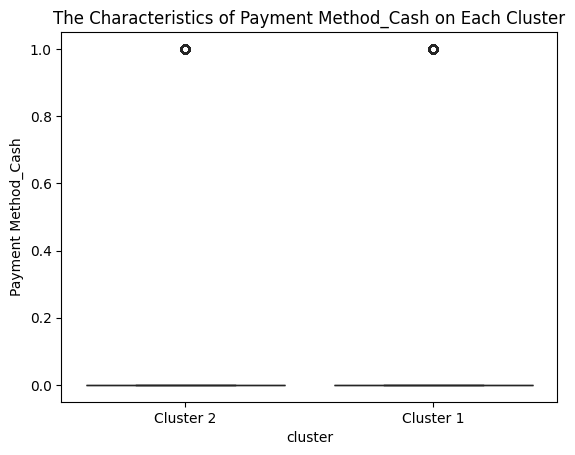

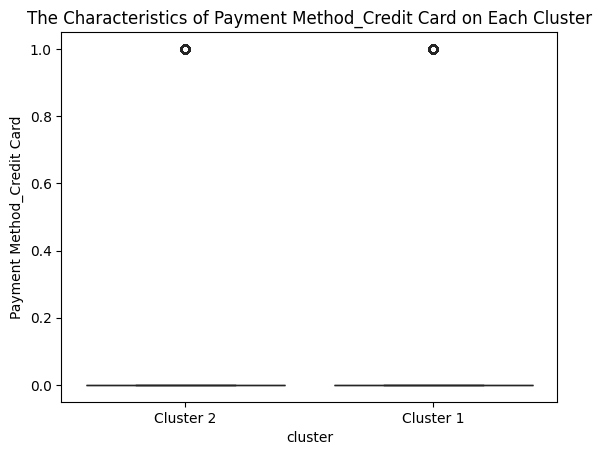

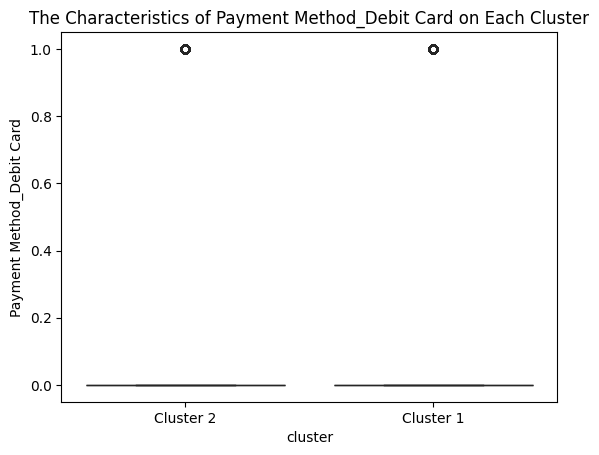

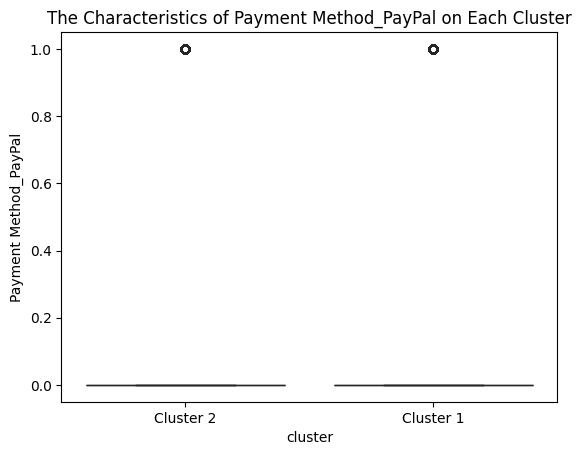

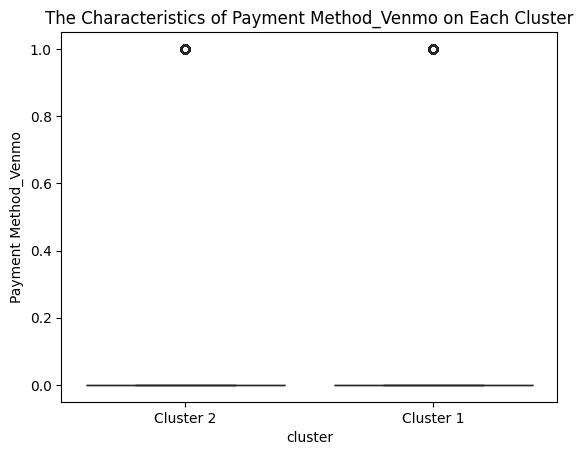

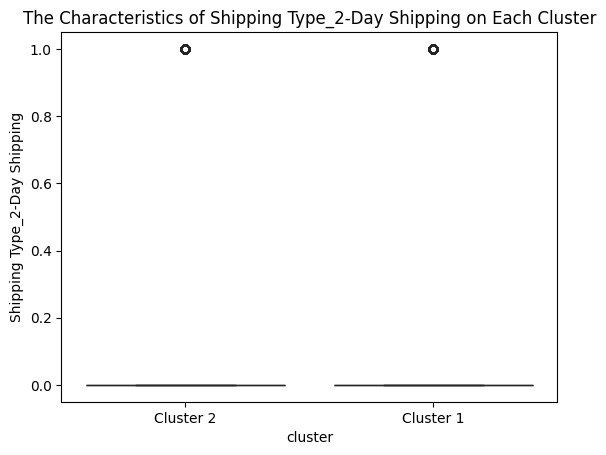

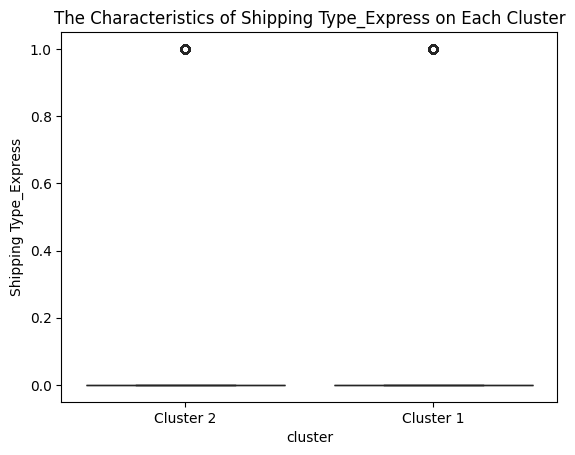

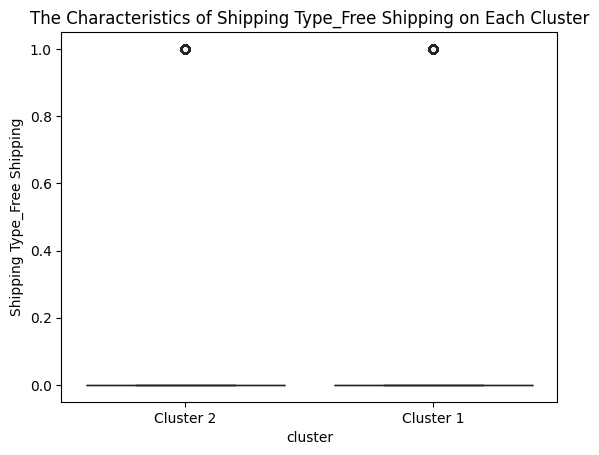

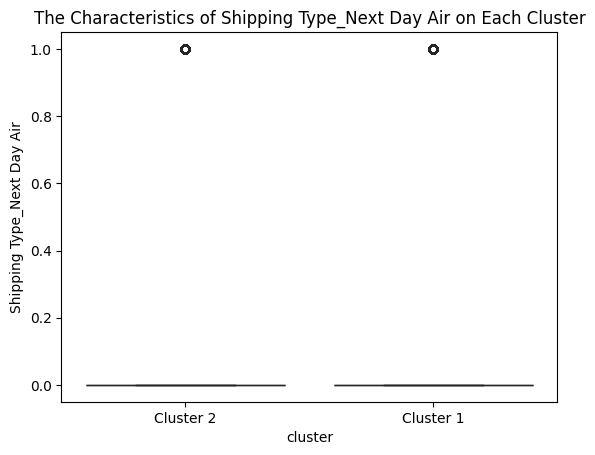

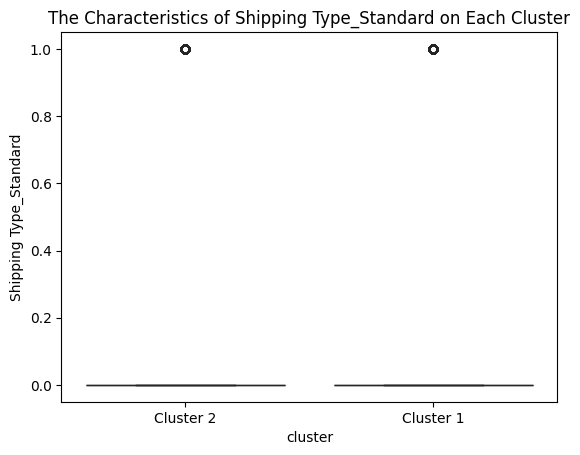

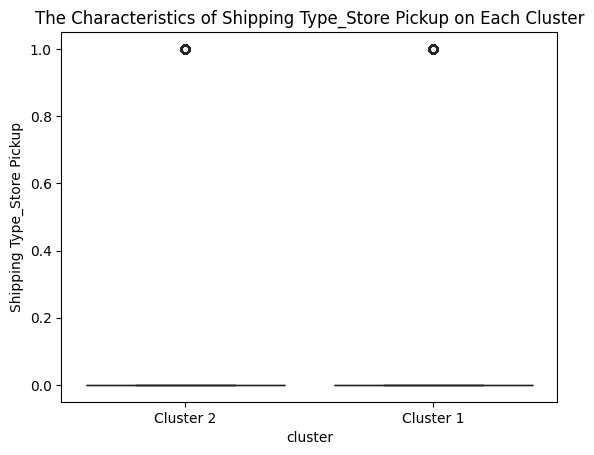

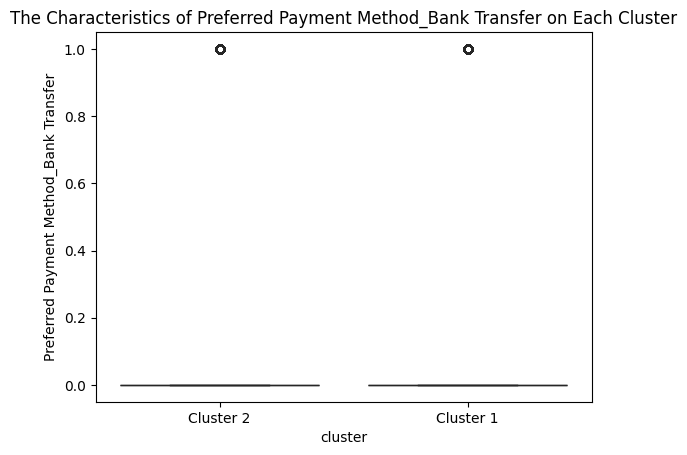

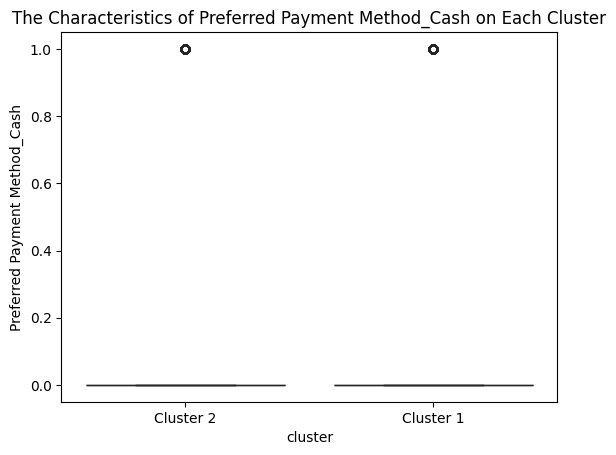

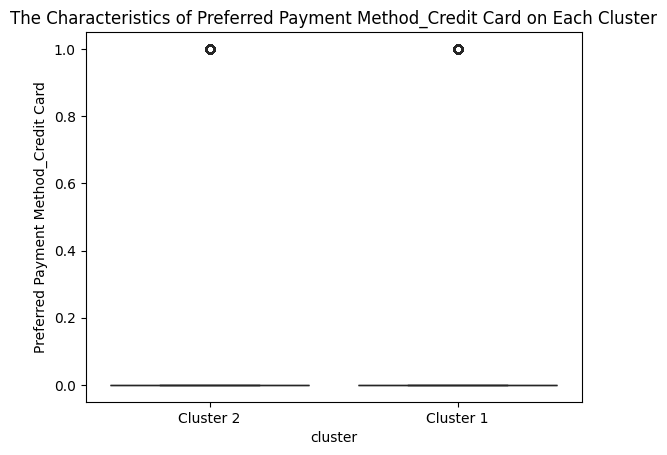

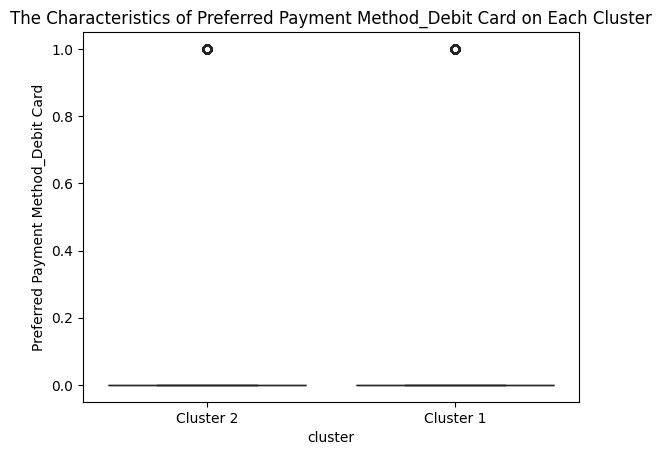

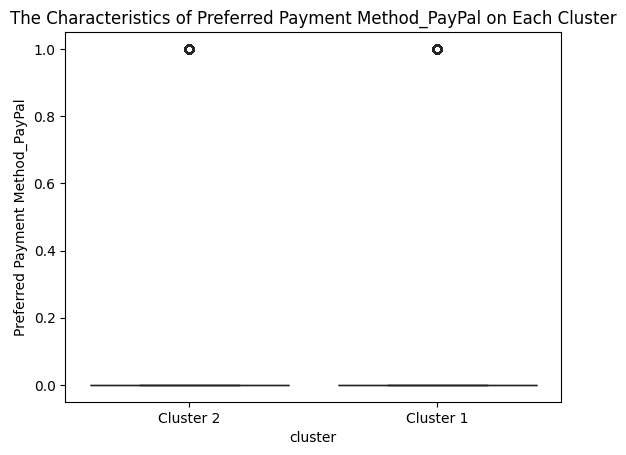

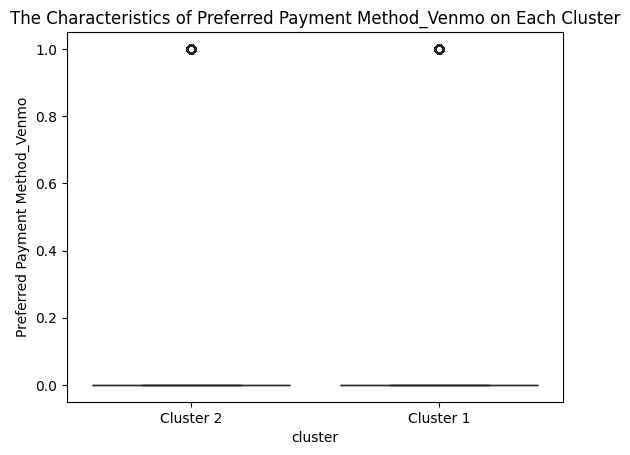

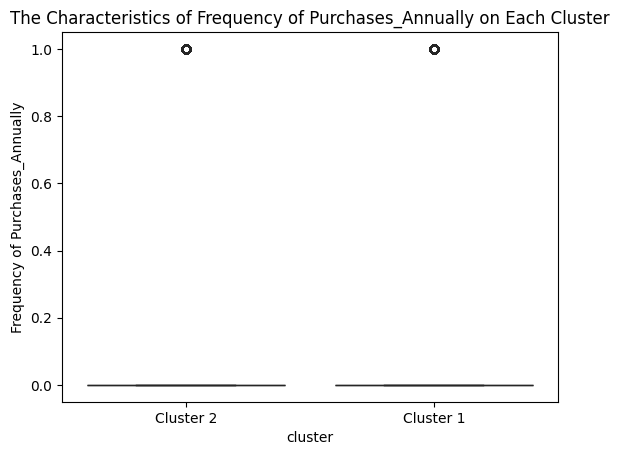

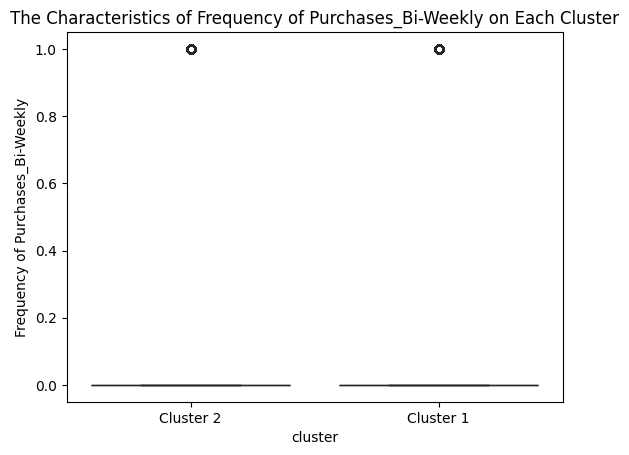

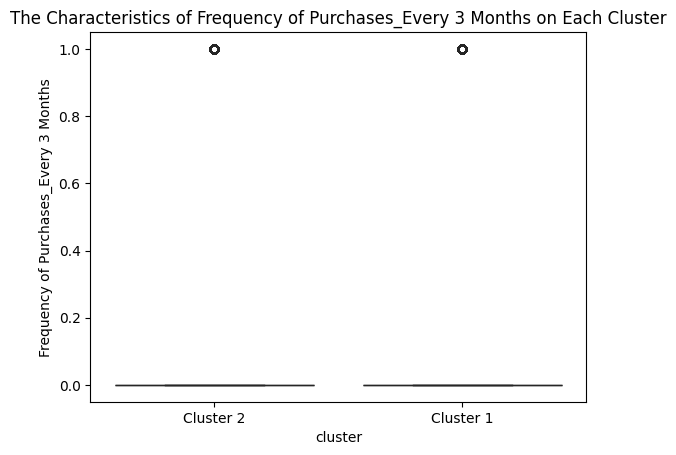

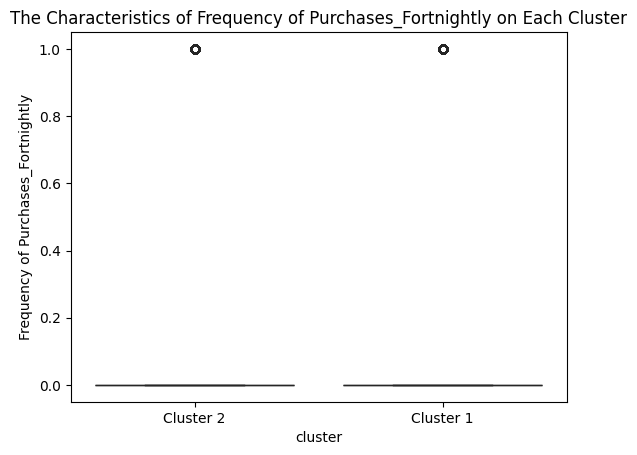

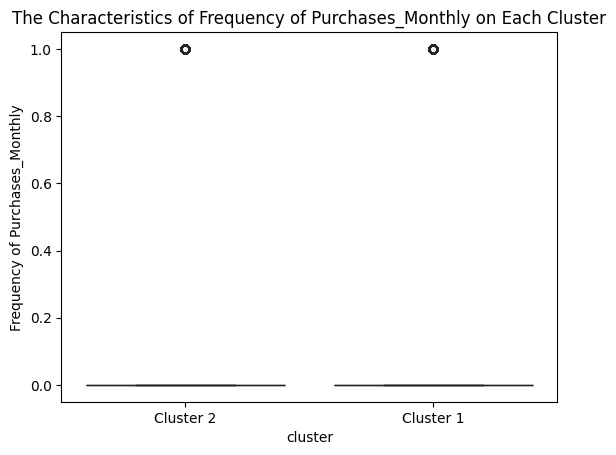

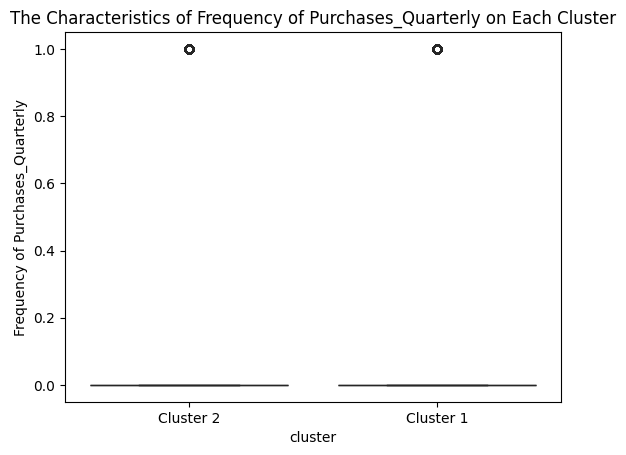

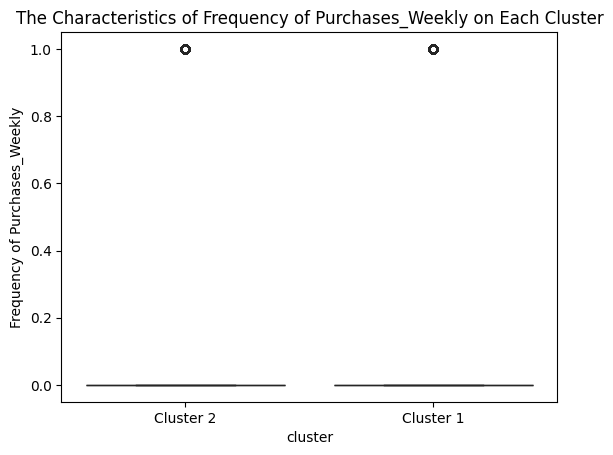

In [319]:
for column in selectedColumns:
    sns.boxplot(x= df2['cluster'], y = df2[column], color = 'navy')
    plt.title(f"The Characteristics of {column} on Each Cluster")
    plt.show()

### CONCLUSION

Based on the showen graphs, it can be concluded that the customers are segemented into 2 clusters, which each cluster has few unique things that can significanly differentiate between each cluster, consists of:  
* The 1st Cluster: customers on this cluster are giving the negative review rating, and all of them are shopping during the fall, summer and winter seasons.
* The 2nd Cluster: in the other side, the customers on this cluster are giving a positive review rating, and all of them are shopping during the spiring season.   
 
These two clusters are significanly different, and it is identifying that the model has succedd to segmented the customer behaviour as well.  

### INSIGHT

The segmented cluster characteristics may turns out to an actionable insight, that the most promotional type can be implemented during the fall, winter and summer season to increase the sentiment of the customer that they can have a good review in order to increasing a customer satisfaction and return rate to the store